In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.utils import resample, shuffle
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, learning_curve, train_test_split
from sklearn.metrics import f1_score, confusion_matrix ,accuracy_score
from sklearn.metrics import precision_score, recall_score

### Data understanding

In [8]:
data = pd.read_csv('../input/KaggleV2-May-2016.csv')
data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [9]:
n_rows = data.shape[0]
n_cols = data.shape[1]
print('The dataset has', n_rows, 'rows and', n_cols, 'features')

The dataset has 110527 rows and 14 features


**Does miss an appointment before influences on missing again?**


In [10]:
data['No-show'] = data['No-show'].replace({'No':0, 'Yes':1})

In [11]:
# engineer feature missed_appointment before
missed_appointment = data.groupby('PatientId')['No-show'].sum()
missed_appointment = missed_appointment.to_dict()
data['missed_appointment_before'] = data.PatientId.map(lambda x: 1 if missed_appointment[x]>0 else 0)
data['missed_appointment_before'].corr(data['No-show'])

0.6298313265252282

**Is gender important?**

In [12]:
patients = data.drop_duplicates(subset=['PatientId'])
n_patients = patients.shape[0]
count = patients.Gender.value_counts()
n_women = count.values[0]
n_men = count.values[1]
print('Proportion of the dataset that are women: {0:2.1f}%'.format(100*n_women/n_patients))
print('Proportion of the dataset that are men: {0:2.1f}%'.format(100*n_men/n_patients))

Proportion of the dataset that are women: 64.3%
Proportion of the dataset that are men: 35.7%


In [13]:
#separate in 2 groups
show = data[data['No-show']==0]
no_show = data[data['No-show']==1]
n_show = show.shape[0]
n_no_show = no_show.shape[0]
print('Percentage of persons that do not miss appointments:{0: 2.2f}%'.format(100*n_show/n_rows))
print('Percentage of persons that miss appointments:{0: 2.2f}%'.format(100*n_no_show/n_rows))

Percentage of persons that do not miss appointments: 79.81%
Percentage of persons that miss appointments: 20.19%


**Does the waiting time until the appointment matter?**
    - use features ScheduledDay and AppointmentDay

In [17]:
def map_waiting_interval_to_days(x):
    '''
    Receives an integer representing the number of days until an appointment and
    returns the category it is in.
    '''
    if x ==0 :
        return 'Less than 15 days'
    elif x > 0 and x <= 2:
        return 'Between 1 day and 2 days'
    elif x > 2 and x <= 7:
        return 'Between 3 days and 7 days'
    elif x > 7 and x <= 31:
        return 'Between 7 days and 31 days'
    else:
        return 'More than 1 month'

In [18]:
d = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
data['mapped_AppointmentDay'] = data['AppointmentDay'].map(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
data['mapped_ScheduledDay'] = data['ScheduledDay'].map(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
data['waiting_interval'] = abs(data['mapped_ScheduledDay'] - data['mapped_AppointmentDay'])
data['waiting_interval_seconds'] = data['waiting_interval'].map(lambda x: x.seconds)
data['waiting_interval_days'] = data['waiting_interval'].map(lambda x: x.days)
data['waiting_interval_days'] = data['waiting_interval_days'].map(lambda x: map_waiting_interval_to_days(x))

data['ScheduledDay_month'] = data['mapped_ScheduledDay'].map(lambda x: x.month)
data['ScheduledDay_day'] = data['mapped_ScheduledDay'].map(lambda x: x.day)
data['ScheduledDay_weekday'] = data['mapped_ScheduledDay'].map(lambda x: x.weekday())

data['AppointmentDay_month'] = data['mapped_AppointmentDay'].map(lambda x: x.month)
data['AppointmentDay_day'] = data['mapped_AppointmentDay'].map(lambda x: x.day)
data['AppointmentDay_weekday'] = data['mapped_AppointmentDay'].map(lambda x: x.weekday())
data['AppointmentDay_weekday'] = data['AppointmentDay_weekday'].replace(d)

# separate in 2 groups
show = data[data['No-show']==0]
no_show = data[data['No-show']==1]
n_show = show.shape[0]
n_no_show = no_show.shape[0]

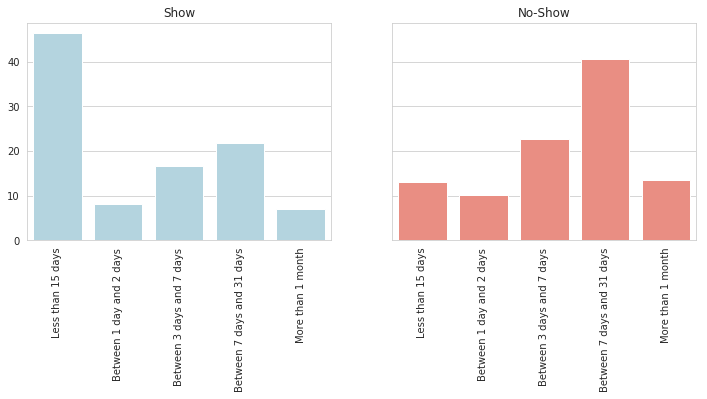

In [19]:
levels = ['Less than 15 days','Between 1 day and 2 days','Between 3 days and 7 days',
'Between 7 days and 31 days','More than 1 month']

grouped = show.groupby(by='waiting_interval_days')
count_days1 = grouped.waiting_interval_days.count().reindex(index = levels)
count_days1 = 100*count_days1/show.shape[0]

grouped = no_show.groupby(by='waiting_interval_days')
count_days2 = grouped.waiting_interval_days.count().reindex(index = levels)
count_days2 = 100*count_days2/no_show.shape[0]

sns.set_style("whitegrid")
f, ax = plt.subplots(1, 2,figsize=(12, 4),sharey=True)
g1 = sns.barplot(x=count_days1.index, y=count_days1.values, 
                color='lightblue',ax=ax[0])
g1.set_xticklabels(levels, rotation=90);
g1.set_xlabel('');
g1.set_title('Show');
g2 = sns.barplot(x=count_days2.index, y=count_days2.values, 
                color='salmon',ax=ax[1])
g2.set_xticklabels(levels, rotation=90);
g2.set_xlabel('');
g2.set_title('No-Show');

**Does age matter?**	

In [20]:
def map_age(x):
    '''
    Receives an integer and returns the age category that this age is in.
    '''
    if x < 12:
        return 'Child'
    elif x > 12 and x < 18:
        return 'Teenager'
    elif x>=20 and x<25:
        return 'Young Adult'
    elif x>=25 and x<60:
        return 'Adult'
    else:
        return 'Senior'
data['mapped_Age'] = data['Age'].map(lambda x: map_age(x))
patients['mapped_Age'] = patients['Age'].map(lambda x: map_age(x))

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


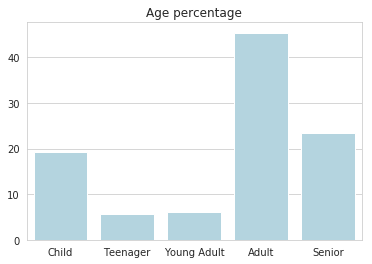

In [21]:
ages = ['Child','Teenager','Young Adult','Adult','Senior']
n_patients = patients.shape[0]
grouped = patients.groupby(by='mapped_Age')
count_ages = grouped.Age.count().reindex(index = ages)
g = sns.barplot(x=count_ages.index, y=count_ages.values*(100/n_patients), color='lightblue');
g.set_title('Age percentage');
g.set_xlabel('');

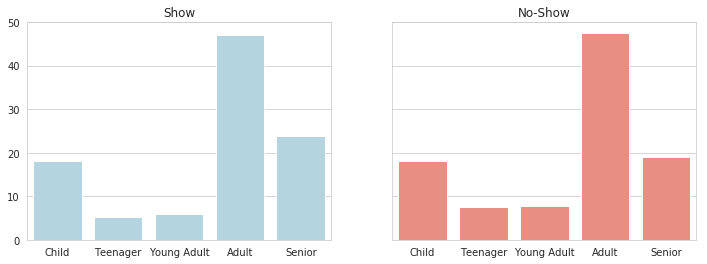

In [22]:
show = data[data['No-show']==0]
no_show = data[data['No-show']==1]
n_show = show.shape[0]
n_no_show = no_show.shape[0]
ages = ['Child','Teenager','Young Adult','Adult','Senior']

# count ages for group which didnt miss appointment
grouped = show.groupby(by='mapped_Age')
count_ages1 = grouped.Age.count().reindex(index = ages)
count_ages1 = count_ages1*(100/show.shape[0])

# count ages for group which missed appointment
grouped = no_show.groupby(by='mapped_Age')
count_ages2 = grouped.Age.count().reindex(index = ages)
count_ages2 = count_ages2*(100/no_show.shape[0])

sns.set_style("whitegrid")
f, ax = plt.subplots(1, 2,figsize=(12, 4),sharey=True)
g1 = sns.barplot(x=count_ages1.index, y=count_ages1.values, 
            color='lightblue',ax=ax[0])
g1.set_xlabel('');
g1.set_title('Show');
g2 = sns.barplot(x=count_ages2.index, y=count_ages2.values, 
            color='salmon',ax=ax[1]);
g2.set_xlabel('');
g2.set_title('No-Show');

**Hipertension, Diabetes, Alcoholism, Handcap**

In [23]:
patients = data.drop_duplicates(subset=['PatientId'])
patients[['Hipertension','Diabetes','Alcoholism','Handcap']].sum(axis=0)/patients.shape[0]

Hipertension    0.196504
Diabetes        0.070884
Alcoholism      0.024174
Handcap         0.020113
dtype: float64

In [24]:
data['haveDisease'] = data.Alcoholism | data.Handcap | data.Diabetes | data.Hipertension

**Check correlation of the features**

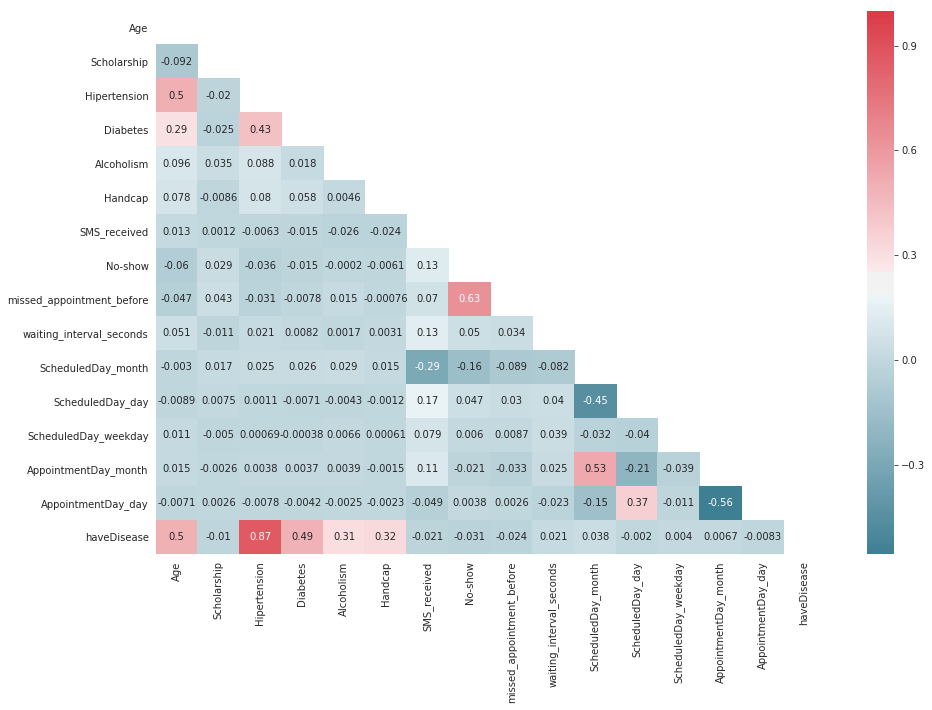

In [25]:
fig, ax = plt.subplots(figsize=[15,10])
data = data.drop(columns=['AppointmentID', 'PatientId'])
cor=data.corr()
mask = np.zeros_like(cor)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
ax = sns.heatmap(cor, xticklabels=cor.columns, yticklabels=cor.columns, 
            annot=True, cmap=cmap, mask=mask);

### Data preparation
    - check for missing data
    - create new features and process data
    - one hot encode categorical features

In [26]:
# Check for missing values
data.isnull().sum().any()

False

In [27]:
def process_data(data):
    '''
    Receives the dataset, clean data and engineer new features. 
    Return cleaned dataset with features that will be used for training model.
    '''
    d = {0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'}
    data['mapped_AppointmentDay'] = data['AppointmentDay'].map(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
    data['mapped_ScheduledDay'] = data['ScheduledDay'].map(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
    data['waiting_interval'] = abs(data['mapped_ScheduledDay'] - data['mapped_AppointmentDay'])
    data['waiting_interval_days'] = data['waiting_interval'].map(lambda x: x.days)
    data['waiting_interval_days'] = data['waiting_interval_days'].map(lambda x: map_waiting_interval_to_days(x))
    
    data['ScheduledDay_month'] = data['mapped_ScheduledDay'].map(lambda x: x.month)
    data['ScheduledDay_day'] = data['mapped_ScheduledDay'].map(lambda x: x.day)
    data['ScheduledDay_weekday'] = data['mapped_ScheduledDay'].map(lambda x: x.weekday())
    data['ScheduledDay_weekday'] = data['ScheduledDay_weekday'].replace(d)

    data['AppointmentDay_month'] = data['mapped_AppointmentDay'].map(lambda x: x.month)
    data['AppointmentDay_day'] = data['mapped_AppointmentDay'].map(lambda x: x.day)
    data['AppointmentDay_weekday'] = data['mapped_AppointmentDay'].map(lambda x: x.weekday())
    data['AppointmentDay_weekday'] = data['AppointmentDay_weekday'].replace(d)
    
    data['No-show'] = data['No-show'].replace({'Yes':1, 'No':0})
   
    missed_appointment = data.groupby('PatientId')['No-show'].sum()
    missed_appointment = missed_appointment.to_dict()
    data['missed_appointment_before'] = data.PatientId.map(lambda x: 1 if missed_appointment[x]>0 else 0)
    data['mapped_Age'] = data['Age'].map(lambda x: map_age(x))
    data['Gender'] = data['Gender'].replace({'F':0, 'M':1})
    data['haveDisease'] = data.Alcoholism | data.Handcap | data.Diabetes | data.Hipertension

    data = data.drop(columns=['waiting_interval', 'AppointmentDay', 'ScheduledDay',
                             'PatientId','Age', 'mapped_ScheduledDay',
                             'mapped_AppointmentDay', 'AppointmentID', 
                              'Alcoholism','Handcap','Diabetes','Hipertension'])
    
    return data

In [28]:
def one_hot_encode(data):
    return pd.get_dummies(data)

In [30]:
data = pd.read_csv('../input/KaggleV2-May-2016.csv')
processed_data = process_data(data)
processed_data.head()

,Gender,Neighbourhood,Scholarship,SMS_received,No-show,waiting_interval_days,ScheduledDay_month,ScheduledDay_day,ScheduledDay_weekday,AppointmentDay_month,AppointmentDay_day,AppointmentDay_weekday,missed_appointment_before,mapped_Age,haveDisease
0,0,JARDIM DA PENHA,0,0,0,Less than 15 days,4,29,Friday,4,29,Friday,0,Senior,1
1,1,JARDIM DA PENHA,0,0,0,Less than 15 days,4,29,Friday,4,29,Friday,0,Adult,0
2,0,MATA DA PRAIA,0,0,0,Less than 15 days,4,29,Friday,4,29,Friday,0,Senior,0
3,0,PONTAL DE CAMBURI,0,0,0,Less than 15 days,4,29,Friday,4,29,Friday,1,Child,0
4,0,JARDIM DA PENHA,0,0,0,Less than 15 days,4,29,Friday,4,29,Friday,0,Adult,1


In [31]:
encoded_data = one_hot_encode(processed_data)
encoded_data.head()

,Gender,Scholarship,SMS_received,No-show,ScheduledDay_month,ScheduledDay_day,AppointmentDay_month,AppointmentDay_day,missed_appointment_before,haveDisease,Neighbourhood_AEROPORTO,Neighbourhood_ANDORINHAS,Neighbourhood_ANTÔNIO HONÓRIO,Neighbourhood_ARIOVALDO FAVALESSA,Neighbourhood_BARRO VERMELHO,Neighbourhood_BELA VISTA,Neighbourhood_BENTO FERREIRA,Neighbourhood_BOA VISTA,Neighbourhood_BONFIM,Neighbourhood_CARATOÍRA,Neighbourhood_CENTRO,Neighbourhood_COMDUSA,Neighbourhood_CONQUISTA,Neighbourhood_CONSOLAÇÃO,Neighbourhood_CRUZAMENTO,Neighbourhood_DA PENHA,Neighbourhood_DE LOURDES,Neighbourhood_DO CABRAL,Neighbourhood_DO MOSCOSO,Neighbourhood_DO QUADRO,Neighbourhood_ENSEADA DO SUÁ,Neighbourhood_ESTRELINHA,Neighbourhood_FONTE GRANDE,Neighbourhood_FORTE SÃO JOÃO,Neighbourhood_FRADINHOS,Neighbourhood_GOIABEIRAS,Neighbourhood_GRANDE VITÓRIA,Neighbourhood_GURIGICA,Neighbourhood_HORTO,Neighbourhood_ILHA DAS CAIEIRAS,...,Neighbourhood_SANTA HELENA,Neighbourhood_SANTA LUÍZA,Neighbourhood_SANTA LÚCIA,Neighbourhood_SANTA MARTHA,Neighbourhood_SANTA TEREZA,Neighbourhood_SANTO ANDRÉ,Neighbourhood_SANTO ANTÔNIO,Neighbourhood_SANTOS DUMONT,Neighbourhood_SANTOS REIS,Neighbourhood_SEGURANÇA DO LAR,Neighbourhood_SOLON BORGES,Neighbourhood_SÃO BENEDITO,Neighbourhood_SÃO CRISTÓVÃO,Neighbourhood_SÃO JOSÉ,Neighbourhood_SÃO PEDRO,Neighbourhood_TABUAZEIRO,Neighbourhood_UNIVERSITÁRIO,Neighbourhood_VILA RUBIM,waiting_interval_days_Between 1 day and 2 days,waiting_interval_days_Between 3 days and 7 days,waiting_interval_days_Between 7 days and 31 days,waiting_interval_days_Less than 15 days,waiting_interval_days_More than 1 month,ScheduledDay_weekday_Friday,ScheduledDay_weekday_Monday,ScheduledDay_weekday_Saturday,ScheduledDay_weekday_Thursday,ScheduledDay_weekday_Tuesday,ScheduledDay_weekday_Wednesday,AppointmentDay_weekday_Friday,AppointmentDay_weekday_Monday,AppointmentDay_weekday_Saturday,AppointmentDay_weekday_Thursday,AppointmentDay_weekday_Tuesday,AppointmentDay_weekday_Wednesday,mapped_Age_Adult,mapped_Age_Child,mapped_Age_Senior,mapped_Age_Teenager,mapped_Age_Young Adult
0,0,0,0,0,4,29,4,29,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,4,29,4,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,4,29,4,29,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,4,29,4,29,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,4,29,4,29,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


### Model

**1. Naive predictor:**
    - predict class with majority (No-show==0) for all cases

In [32]:
print('All data - Naive predictor accuracy: {:2.2f}%'.format(100 - (100*encoded_data['No-show'].sum()/encoded_data.shape[0])))

All data - Naive predictor accuracy: 79.81%


In [33]:
# row: true label ; columns: predictions
tn, fp, fn, tp = confusion_matrix(encoded_data['No-show'], np.zeros(encoded_data.shape[0])).ravel()
(tn, fp, fn, tp)

(88208, 0, 22319, 0)

- We can see that the naive model does not classify correctly any of out positivies entries. The 22319 false negatives (this model have poor recall)

- We want to retrieve individues that will miss the appointment (our True Positives) and also avoid classify persons that will show up as a no-show. We need a metric that takes precision and recall into consideration, therefore F1 score seems a good choice.

#### Using dataset without dealing with the class imbalance

In [34]:
X = encoded_data.drop(columns='No-show')
y = encoded_data['No-show']

In [35]:
scaler = MinMaxScaler()
X_std = scaler.fit_transform(X)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [36]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.30, random_state=42)

print('Train size:{}'.format(X_train.shape))
print('Test size:{}'.format(X_test.shape))

Train size:(77368, 112)
Test size:(33159, 112)


In [37]:
clf1 = RandomForestClassifier(random_state = 0)
clf1.fit(X_train, y_train)
y_preds = clf1.predict(X_test)

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [38]:
print('RF - Accuracy: {:2.2f}%'.format(accuracy_score(y_test, y_preds) * 100))
print('RF - Precision score: {:2.2f}%'.format(precision_score(y_test, y_preds)*100))
print('RF - Recall score: {:2.2f}%'.format(recall_score(y_test, y_preds)*100))
print('RF - F1-score: {:2.2f}%'.format(f1_score(y_test, y_preds) * 100))

RF - Accuracy: 86.36%
RF - Precision score: 66.72%
RF - Recall score: 63.45%
RF - F1-score: 65.04%


In [39]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
confusion_matrix(y_test, y_preds)

array([[24426,  2099],
       [ 2425,  4209]])

- The accuracy is 86%, which is small improvement from the 79.81% of the naive classifier (predict 0 for every entry). Since accuracy can be misleading, so we take a look in other models

- The F1-score is at 65%, which is low. Lets try a model more robust to class imbalance.

In [40]:
clf1 = GradientBoostingClassifier(random_state = 0)
clf1.fit(X_train, y_train)
y_preds = clf1.predict(X_test)
print('GB - Accuracy: {:2.2f}%'.format(accuracy_score(y_test, y_preds) * 100))
print('GB - Precision score: {:2.2f}%'.format(precision_score(y_test, y_preds)*100))
print('GB - Recall score: {:2.2f}%'.format(recall_score(y_test, y_preds)))
print('GB - F1-score: {:2.2f}%'.format(f1_score(y_test, y_preds) * 100))

GB - Accuracy: 87.32%
GB - Precision score: 63.78%
GB - Recall score: 0.85%
GB - F1-score: 72.76%


In [41]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
confusion_matrix(y_test, y_preds)

array([[23335,  3190],
       [ 1016,  5618]])

-  The F1-score for this model is at 72% which was an improve from the RF model.
- In the next section we will try some approaches to deal with the imbalance of the dataset and see if we can improve this.

### Downsampling and upweighting approach
Follow the steps of https://developers.google.com/machine-learning/data-prep/construct/sampling-splitting/imbalanced-data before using RF (image from link)
![](https://developers.google.com/machine-learning/data-prep/images/downsampling-upweighting-v5.svg)    

In [42]:
print(processed_data.shape)
print(encoded_data.shape)

# separates data in two groups
show = data[data['No-show']==0]
no_show = data[data['No-show']==1]
n_show = show.shape[0]
n_no_show = no_show.shape[0]
print('Proportion of minority class: {:2.2f}%'.format(100*no_show.shape[0]/n_rows))
print('Proportion of majority class: {:2.2f}%'.format(100*show.shape[0]/n_rows))

(110527, 15)
(110527, 113)
Proportion of minority class: 20.19%
Proportion of majority class: 79.81%


In [43]:
no_show.shape[0]/show.shape[0] # 1 positive no-show for 4 negatives no-show

0.25302693633230544

- This mean that for each sample with no-show==1 there is 4 samples with no-show==0.
- The downsampling factor of 4 is used, then after downsampling the classes proportion will be almost the same

In [44]:
# Calculates how many samples we resample from the majority class
downsampling_factor = 4
n_samples = round(show.shape[0]/downsampling_factor)
n_samples

22052

In [45]:
# separate classes
df_majority = encoded_data[encoded_data['No-show']==0]
df_minority = encoded_data[encoded_data['No-show']==1]
 
# downsample without replacement majority class
df_majority_downsampled = resample(df_majority, replace=False, n_samples=n_samples, random_state=0)  
 
# save the index to use when perform the upweight of the samples
resampled_index = df_majority_downsampled.index

# combine minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# shuffle dataframe
df_downsampled = shuffle(df_downsampled)

# take a look into proportion after resampling
df_majority = df_downsampled[df_downsampled['No-show']==0]
df_minority = df_downsampled[df_downsampled['No-show']==1]

print('Proportion of minority class after downsampling: {:2.2f}%'.format(100*df_minority.shape[0]/df_downsampled.shape[0]))
print('Proportion of majority class after downsampling: {:2.2f}%'.format(100*df_majority.shape[0]/df_downsampled.shape[0]))

Proportion of minority class after downsampling: 50.30%
Proportion of majority class after downsampling: 49.70%


**Upweight the samples**
    - {example_weight} = {original_weight} x {downsampling_factor}

In [46]:
# create column of original index before resampling
df_downsampled = df_downsampled.reset_index()

# get the weights
weight_factor = round(downsampling_factor)
weights = np.ones(df_downsampled.shape[0])

# iforiginal index is in resampled_index change weight
cols = df_downsampled.columns
df_downsampled.columns = ['original_index'] + list(cols)[1:]
df_downsampled['weight'] = df_downsampled.original_index.map(lambda x: weight_factor if x in resampled_index else 1).values

**Scale data and split data into training and testing**
    - scale all features except 'original_index', 'weight' which are used to calculate the weights to pass as sample_weight parameter of Random Forest method .fit()

In [47]:
X = df_downsampled.drop(columns='No-show')
y = df_downsampled['No-show']

In [48]:
scaler = MinMaxScaler()
X_to_scale = X.drop(columns=['original_index', 'weight'])
cols = X_to_scale.columns
X_std = scaler.fit_transform(X_to_scale)
X_std = pd.DataFrame(X_std)

# reappend 'original_index', 'weight' to the dataframe
X_std = X_std.join(X[['original_index', 'weight']])
X_std.columns = list(cols) + ['original_index', 'weight']

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.30, random_state=0)

print('Train size:{}'.format(X_train.shape))
print('Test size:{}'.format(X_test.shape))

Train size:(31059, 114)
Test size:(13312, 114)


In [50]:
weights = X_train.weight
X_train = X_train.drop(columns=['original_index','weight'])
X_test = X_test.drop(columns=['original_index','weight'])

### RF

In [51]:
clf1 = RandomForestClassifier(random_state = 0)
clf1.fit(X_train, y_train, sample_weight=weights)
y_preds = clf1.predict(X_test)
print('RF - Accuracy: {:2.2f}%'.format(accuracy_score(y_test, y_preds) * 100))
print('RF - Precision score: {:2.2f}%'.format(precision_score(y_test, y_preds)*100))
print('RF - Recall score: {:2.2f}%'.format(recall_score(y_test, y_preds)*100))
print('RF - F1-score: {:2.2f}%'.format(f1_score(y_test, y_preds) * 100))

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RF - Accuracy: 88.22%
RF - Precision score: 85.58%
RF - Recall score: 92.00%
RF - F1-score: 88.67%


In [52]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
confusion_matrix(y_test, y_preds)

array([[5606, 1034],
       [ 534, 6138]])

- Seems an improvement compared with the previous F1-score: 65.04% of RF without downsampling

In [53]:
clf = GradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
y_preds = clf.predict(X_test)
acc = accuracy_score(y_test, y_preds) * 100
precision = precision_score(y_test, y_preds)*100
recall = recall_score(y_test, y_preds)*100
f_score = f1_score(y_test, y_preds) * 100

print('GB - Accuracy: {:2.2f}%'.format(acc))
print('GB - Precision score: {:2.2f}%'.format(precision))
print('GB - Recall score: {:2.2f}%'.format(recall))
print('GB - F1-score: {:2.2f}%'.format(f_score))

GB - Accuracy: 88.95%
GB - Precision score: 83.04%
GB - Recall score: 97.96%
GB - F1-score: 89.89%


In [ ]:
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
confusion_matrix(y_test, y_preds)

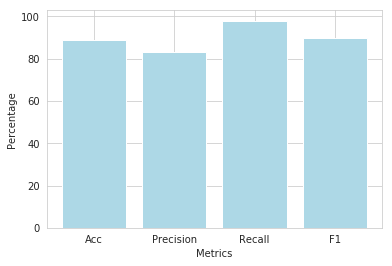

In [54]:
#http://benalexkeen.com/bar-charts-in-matplotlib/
%matplotlib inline

x = ['Acc', 'Precision','Recall', 'F1']
metrics = [acc, precision, recall, f_score]
plt.gca().yaxis.grid(True)
x_pos = [i for i, _ in enumerate(x)]
plt.bar(x_pos, metrics, color='lightblue')
plt.xlabel("Metrics")
plt.ylabel("Percentage")
plt.xticks(x_pos, x)
plt.show()